Define function to interpolate for

In [1]:
import torch
from torch import Tensor
def fn_interpolate(x: Tensor):
    return torch.exp(x)

Sample points to work with

In [3]:
N = 5
x = torch.linspace(0, 2, N)
y = fn_interpolate(x)
#######
k = 1
m = 2*k+1
degree = 1

In [4]:
import sys
sys.path.insert(0, '../../../modules')

from nn_rbf_phs_poly import RBFInterpolant
import torch

# Use estimation of starting parameters
nn_interpolator = RBFInterpolant(k=1, centers=x, degree=degree)

Create matrix `A` using previous code, as well as vectors `lda`, `f`

In [5]:
Interpolation_Matrix = nn_interpolator.get_interpolation_matrix(x)
print(Interpolation_Matrix)
print(torch.linalg.cond(Interpolation_Matrix))

tensor([[0.0000, 0.1250, 1.0000, 3.3750, 8.0000, 1.0000, 0.0000],
        [0.1250, 0.0000, 0.1250, 1.0000, 3.3750, 1.0000, 0.5000],
        [1.0000, 0.1250, 0.0000, 0.1250, 1.0000, 1.0000, 1.0000],
        [3.3750, 1.0000, 0.1250, 0.0000, 0.1250, 1.0000, 1.5000],
        [8.0000, 3.3750, 1.0000, 0.1250, 0.0000, 1.0000, 2.0000],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.0000, 0.0000],
        [0.0000, 0.5000, 1.0000, 1.5000, 2.0000, 0.0000, 0.0000]])
tensor(202.2683)


In [6]:
f = torch.cat((y, torch.zeros(degree + 1)))
lda = torch.nn.Parameter(data = torch.randn(N + degree + 1))

# Preemptively calculate solution by matrix inversion
lda_optimum = torch.linalg.solve(Interpolation_Matrix, f)
lda_optimum

tensor([ 0.3344, -0.3229,  0.7001, -1.7691,  1.0575, -2.1490,  3.7369])

In [8]:
params_number = sum(p.numel() for p in nn_interpolator.parameters() if p.requires_grad) # number of parameters
params_number

7

## Work with MSE loss function

Train model with MSE

In [9]:
max_iterations = 200000
parameters_progress_mse = torch.zeros(size=(1, params_number), requires_grad=False)

# mse = torch.nn.MSELoss()
optimizer = torch.optim.Adam(params=nn_interpolator.parameters(), lr=1e-3)
for i in range(max_iterations):
    loss = torch.sum((nn_interpolator(x) - y) ** 2) / N
    print(f'{i}: {loss.item()}', end='\r')
    if loss < 1e-14:
        break
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # Update log
    parameters_progress_mse = torch.cat((parameters_progress_mse, torch.zeros(1, params_number)))
    parameters_progress_mse[-1, :] = nn_interpolator.get_coefs()

Print computed parameters vs parameters by matrix inversion

In [10]:
print(nn_interpolator.get_coefs())
print(lda_optimum)

tensor([ 0.4659, -0.0097,  0.1767,  0.0112, -0.0336,  1.0553,  1.2304],
       grad_fn=<CatBackward0>)
tensor([ 0.3344, -0.3229,  0.7001, -1.7691,  1.0575, -2.1490,  3.7369])


In [13]:
lda_optimum[:N]

tensor([ 1.2458, -1.4166,  0.7001, -0.6754,  0.1461])

/home/higlesias/tfm-experiments/interpolation_comparison/rbf/phs/../../../modules/nn_rbf_phs.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  else torch.nn.Parameter(torch.tensor(coefs))
/home/higlesias/tfm-experiments/interpolation_comparison/rbf/phs/../../../modules/nn_poly.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.coefs = torch.nn.Parameter(torch.tensor(coefs))


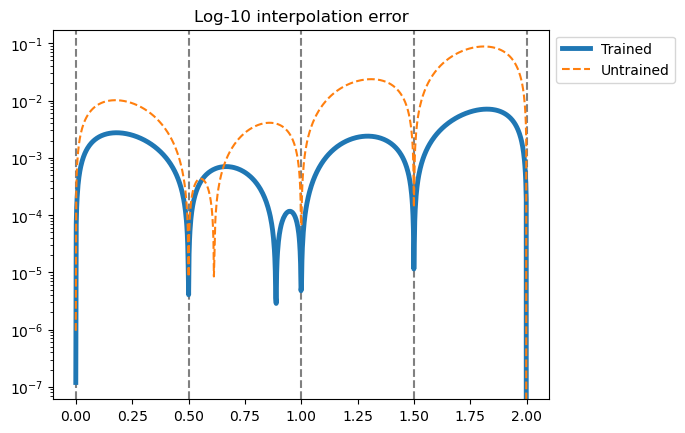

In [11]:
import matplotlib.pyplot as plt

with torch.no_grad():
    nn_interpolator_untrained = RBFInterpolant(k=1, centers=x, degree=degree,
                                               coefs_rbf=lda_optimum[:N], 
                                               coefs_poly=lda_optimum[N:])
    
    x_verification = torch.linspace(0, 2, 1000)
    y_verification = fn_interpolate(x_verification)
    for vertical in x:
        plt.axvline(vertical, color = "grey", linestyle='--')

    plt.semilogy(x_verification, 
                 torch.abs(nn_interpolator(x_verification) - y_verification), 
                 label="Trained", linewidth='3.5')
    plt.semilogy(x_verification, 
                 torch.abs(nn_interpolator_untrained(x_verification) - y_verification), 
                 label="Untrained", linestyle='--')

    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.title("Log-10 interpolation error")
    plt.show()

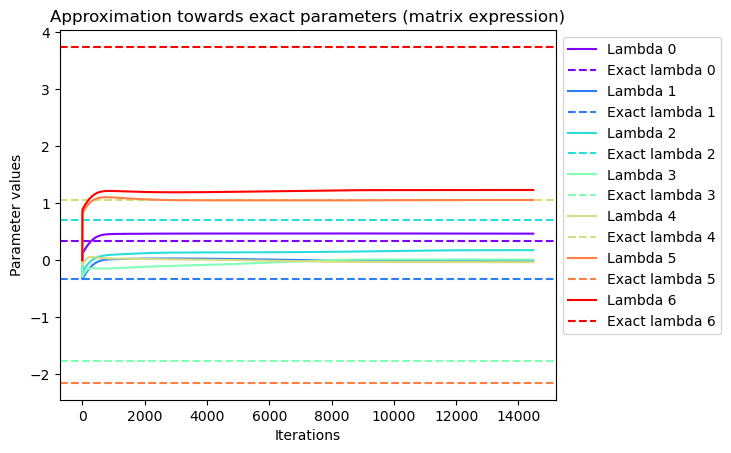

In [30]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

colors = cm.rainbow(torch.linspace(0, 1, params_number))

for i in range(params_number):
    plt.plot(parameters_progress_mse[:, i].detach().numpy(), label=f"Lambda {i}", color = colors[i])
    plt.axhline(lda_optimum[i], color = colors[i], linestyle='dashed', label=f'Exact lambda {i}')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.ylabel('Parameter values')
plt.xlabel('Iterations')
plt.title('Approximation towards exact parameters (matrix expression)')
plt.show()